#EmDet

Purpose of this project is to build an NLP model to predict the emotion from a given sentence

## Get Data

In [1]:
!pip install datasets

from datasets import load_dataset

dataset = load_dataset("emotion")

     |████████████████████████████████| 290 kB 5.4 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 
     |████████████████████████████████| 125 kB 44.7 MB/s 
     |████████████████████████████████| 243 kB 41.2 MB/s 
     |████████████████████████████████| 1.1 MB 33.3 MB/s 
     |████████████████████████████████| 271 kB 54.1 MB/s 
     |████████████████████████████████| 192 kB 50.5 MB/s 
     |████████████████████████████████| 160 kB 45.5 MB/s 


Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
# Check the imported dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Preprocess data

In [3]:
# Split the dataset into training, validation and test datasets
train_data = dataset["train"]
val_data = dataset["validation"]
test_data = dataset["test"]

In [4]:
print(train_data[0])
print(train_data.column_names)
print(train_data.features)

{'text': 'i didnt feel humiliated', 'label': 0}
['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)}


In [5]:
# Turn all the datasets into pd.DataFrame's
import pandas as pd
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [6]:
# Add a description column
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_df['description'] = train_df['label'].map(labels_dict )
val_df['description'] = val_df['label'].map(labels_dict )
test_df['description'] = test_df['label'].map(labels_dict )
train_df.head()

,text,label,description
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [7]:
# Drop the label column
train_df.drop(["label"], axis=1, inplace=True)
val_df.drop(["label"], axis=1, inplace=True)
test_df.drop(["label"], axis=1, inplace=True)
train_df.head()

,text,description
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         16000 non-null  object
 1   description  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [9]:
# Convert abstract text lines into numpy arrays
train_sentences = train_df["text"].to_numpy()
train_labels = train_df["description"].to_numpy()

val_sentences = val_df["text"].to_numpy()
val_labels = val_df["description"].to_numpy()

test_sentences = test_df["text"].to_numpy()
test_labels = test_df["description"].to_numpy()

In [ ]:
# View first 10 lines of training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['i didnt feel humiliated',
        'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
        'im grabbing a minute to post i feel greedy wrong',
        'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
        'i am feeling grouchy',
        'ive been feeling a little burdened lately wasnt sure why that was',
        'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
        'i feel as confused about life as a teenager or as jaded as a year old man',
        'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
        'i feel romantic too'], dtype=object),
 array(['sadness', 'sadness', 'anger', 'love', 'anger', 'sadness',
        'surprise', 'fear', 'joy', 'love'], dtype=object))

## Make numeric labels

We're going to create one hot and label encoded labels.

We could get away with just making label encoded labels, however, TensorFlow's CategoricalCrossentropy loss function likes to have one hot encoded labels 

To numerically encode labels we'll use Scikit-Learn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) classes.



### One hot encode labels

In [10]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_labels.reshape(-1,1))

In [11]:
train_labels_one_hot, train_labels_one_hot.shape

(array([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.]]), (16000, 6))

### Label encode labels

In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [13]:
val_labels_encoded, val_labels_encoded.shape

(array([4, 4, 3, ..., 2, 2, 2]), (2000,))

In [14]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(6, array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
       dtype=object))

## Starting a Series of Modelling Experiments

We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

## Model 0: Getting a baseline

Our first model will be a TF-IDF Multinomial Naive Bayes as recommended by [Scikit-Learn's machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

To build it, we'll create a Scikit-Learn `Pipeline` which uses the [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) aglorithm.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf_idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.641

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(test_sentences)
baseline_preds

array([4, 4, 4, ..., 2, 2, 2])

### Download helper function script

In [15]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-05 19:21:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-05 19:21:47 (59.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [16]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 33.15,
 'f1': 0.2666592569476614,
 'precision': 0.24374814300538186,
 'recall': 0.3315}

## Preparing the data for deep sequence models

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len 

19.1663125

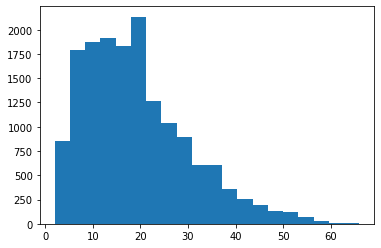

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

Looks like the vast majority of sentences are between 0 and 40 tokens in length.

We can use NumPy's [`percentile`](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html) to find the value which covers 95% of the sentence lengths.

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

41

It looks like 95% of the sentences in our training set have a length of 41 tokens or less.

When we create our tokenization layer, we'll use this value to turn all of our sentences into the same length. Meaning sentences with a length below 41 get padded with zeros and sentences with a length above 41 get truncated (words after 41 get cut off).

## Create text vectorizer layer

To do so, we'll use the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer from TensorFlow.

We'll keep all the parameters default except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence).

In [ ]:
# How many words are in our vocab?
from collections import Counter
results = Counter()
train_df["text"].str.lower().str.split().apply(results.update)
len(results)

15212

In [ ]:
max_tokens = 15200

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"Length of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
im feeling so irritable about todays class
Length of text: 7

Vectorized text:
[[  17    9   15  413   27 3111  338    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


Using the [`get_vocabulary()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) method of our `text_vectorizer` we can find out a few different tidbits about our text.

In [ ]:
# How many words in our training vocabulary
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(text_vocab)}")
print(f"Most common words in vocab: {text_vocab[:5]}")
print(f"Least common words in vocab: {text_vocab[-5:]}")

Number of words in vocab: 15200
Most common words in vocab: ['', '[UNK]', 'i', 'feel', 'and']
Least common words in vocab: ['abou', 'abortion', 'abominable', 'aboard', 'abnormally']


In [ ]:
# Get the config of our text_vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 15200,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 41,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

## Create custom text embedding

We can create a trainable embedding layer using TensorFlow's [`Embedding`](https://www.tensorflow.org/tutorials/text/word_embeddings) layer.

Once again, the main parameters we're concerned with here are the inputs and outputs of our `Embedding` layer.

The `input_dim` parameter defines the size of our vocabulary. And the `output_dim` parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our `text_vectorization` layer as inputs and convert them to feature vectors of size `output_dim`.

In [ ]:
# Create custom text embedding
token_embed = layers.Embedding(input_dim=len(text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentece after vectorization (before the embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentece after embedding: {embedded_sentence}\n")
print(f"Embedded sentece shape: {embedded_sentence.shape}")

Sentence before vectorization:
im feeling so irritable about todays class

Sentece after vectorization (before the embedding):
[[  17    9   15  413   27 3111  338    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentece after embedding: [[[-0.0026126  -0.04726696 -0.00680285 ... -0.03172692 -0.00700514
    0.02098787]
  [-0.00274811 -0.00408995 -0.00378897 ... -0.02445866 -0.00233401
    0.03691867]
  [-0.02096964  0.01959214 -0.04068299 ... -0.00632637  0.04360111
   -0.02015592]
  ...
  [ 0.04160476 -0.0357457   0.00409715 ...  0.00311971  0.02720431
    0.00866594]
  [ 0.04160476 -0.0357457   0.00409715 ...  0.00311971  0.02720431
    0.00866594]
  [ 0.04160476 -0.0357457   0.00409715 ...  0.00311971  0.02720431
    0.00866594]]]

Embedded sentece shape: (1, 41, 128)


## Creating datasets (making sure our data loads as fast as possible)

The main steps we'll want to use with our data is to turn it into a `PrefetchDataset` of batches.

Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, in turn leading to faster training time.

To create a batched `PrefetchDataset` we can use the methods [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch), the parameter [`tf.data.AUTOTUNE`](https://www.tensorflow.org/api_docs/python/tf/data#AUTOTUNE) will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [19]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (6,)), types: (tf.string, tf.float64)>

In [20]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 6)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(24, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.MaxPooling1D(pool_size=2, padding="valid")(x)
x = layers.GlobalAveragePooling1D()(x)  #condense the output of our vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
# Get a summary of the model
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 41)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 41, 128)           1945600   
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 24)            15384     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 24)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 24)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 150   

Checking out the model summary, you'll notice the majority of the trainable parameters are within the embedding layer. If we were to increase the size of the embedding (by increasing the `output_dim` parameter of the `Embedding` layer), the number of trainable parameters would increase dramatically.

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              epochs=5,
                              validation_data=val_dataset)

Epoch 1/5
500/500 [==============================] - 35s 10ms/step - loss: 1.2849 - accuracy: 0.5367 - val_loss: 0.6838 - val_accuracy: 0.8120
Epoch 2/5
500/500 [==============================] - 5s 9ms/step - loss: 0.3734 - accuracy: 0.8909 - val_loss: 0.3833 - val_accuracy: 0.8780
Epoch 3/5
500/500 [==============================] - 5s 9ms/step - loss: 0.1633 - accuracy: 0.9528 - val_loss: 0.3536 - val_accuracy: 0.8970
Epoch 4/5
500/500 [==============================] - 4s 9ms/step - loss: 0.0918 - accuracy: 0.9741 - val_loss: 0.3721 - val_accuracy: 0.8890
Epoch 5/5
500/500 [==============================] - 4s 9ms/step - loss: 0.0615 - accuracy: 0.9830 - val_loss: 0.4089 - val_accuracy: 0.8905


In [ ]:
# Evaluate the model on test_dataset
model_1.evaluate(test_dataset)

63/63 [==============================] - 0s 5ms/step - loss: 0.3827 - accuracy: 0.8815


[0.3826550245285034, 0.8815000057220459]

In [ ]:
# Make predictions
model_1_pred_probs = model_1.predict(test_sentences)
model_1_pred_probs

array([[9.8960521e-04, 3.9587682e-04, 7.2066311e-04, 5.3251242e-05,
        9.9782592e-01, 1.4670425e-05],
       [3.1945447e-03, 3.7235161e-04, 1.5870307e-04, 1.6581711e-05,
        9.9624521e-01, 1.2594937e-05],
       [3.1730095e-03, 1.2908805e-03, 3.5993846e-03, 3.0691057e-04,
        9.9156791e-01, 6.1988918e-05],
       ...,
       [6.4124884e-05, 3.9413131e-05, 9.9761033e-01, 1.9276335e-03,
        1.5132174e-04, 2.0716907e-04],
       [2.8823075e-04, 2.0652098e-05, 9.9694949e-01, 4.1946504e-04,
        2.2524537e-03, 6.9786380e-05],
       [1.3504266e-02, 4.9724308e-01, 2.6836928e-03, 2.4194924e-02,
        3.5249050e-05, 4.6233875e-01]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 4, ..., 2, 2, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 88.14999999999999,
 'f1': 0.8799670709853915,
 'precision': 0.8812635208620407,
 'recall': 0.8815}

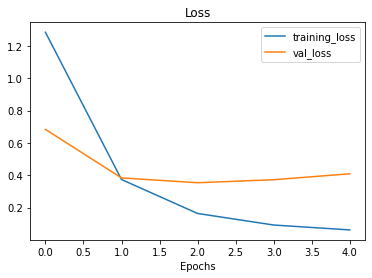

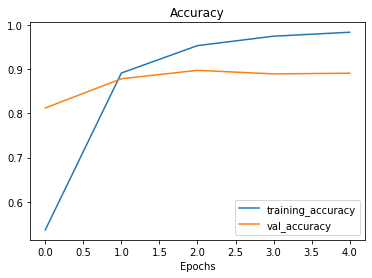

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves
plot_loss_curves(history_model_1)

## Model 2: LSTM

In [ ]:
# Create an embedding layer (new embedding layer for each model)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=len(text_vocab),
                                     output_dim=128,
                                     mask_zero=True,
                                     name="embedding_2")
# Create LSTM model 
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
# x = layers.LSTM(64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequences=True
x = layers.LSTM(48)(x)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 41)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 41, 128)           1945600   
_________________________________________________________________
lstm (LSTM)                  (None, 48)                33984     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 294       
Total params: 1,979,878
Trainable params: 1,979,878
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              epochs=5,
                              validation_data=val_dataset)

Epoch 1/5
500/500 [==============================] - 17s 24ms/step - loss: 1.0288 - accuracy: 0.6285 - val_loss: 0.4999 - val_accuracy: 0.8450
Epoch 2/5
500/500 [==============================] - 11s 21ms/step - loss: 0.2521 - accuracy: 0.9159 - val_loss: 0.3035 - val_accuracy: 0.9000
Epoch 3/5
500/500 [==============================] - 11s 21ms/step - loss: 0.1156 - accuracy: 0.9618 - val_loss: 0.3240 - val_accuracy: 0.8945
Epoch 4/5
500/500 [==============================] - 11s 21ms/step - loss: 0.0735 - accuracy: 0.9754 - val_loss: 0.2945 - val_accuracy: 0.9065
Epoch 5/5
500/500 [==============================] - 11s 21ms/step - loss: 0.0537 - accuracy: 0.9816 - val_loss: 0.3283 - val_accuracy: 0.9040


In [ ]:
# Evaluate the model on test_data
model_2.evaluate(test_dataset)

63/63 [==============================] - 1s 8ms/step - loss: 0.3397 - accuracy: 0.9015


[0.3397454619407654, 0.9014999866485596]

In [ ]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(test_sentences)
model_2_pred_probs

array([[6.9794328e-06, 2.8925135e-05, 1.8583778e-05, 5.3031386e-06,
        9.9993932e-01, 8.7931056e-07],
       [2.5113957e-04, 8.4413427e-05, 3.1356962e-04, 1.1948302e-05,
        9.9933690e-01, 2.0026355e-06],
       [1.0390870e-02, 1.7744983e-03, 3.0590875e-02, 1.2845386e-02,
        9.4352978e-01, 8.6867792e-04],
       ...,
       [2.4471816e-05, 2.2098344e-05, 9.9975592e-01, 1.3632930e-04,
        5.8367208e-05, 2.7294384e-06],
       [1.1643607e-05, 1.2261936e-05, 9.9976331e-01, 1.9368628e-04,
        1.5985945e-05, 3.0404160e-06],
       [5.9461235e-03, 6.3560796e-01, 2.1903161e-03, 1.0372032e-03,
        1.5957406e-03, 3.5362265e-01]], dtype=float32)

In [ ]:
# Convert model_2_pred_probs to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 4, ..., 2, 2, 1])>

In [ ]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 90.14999999999999,
 'f1': 0.9016561120841714,
 'precision': 0.9031413513379316,
 'recall': 0.9015}

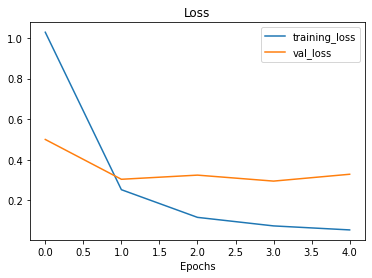

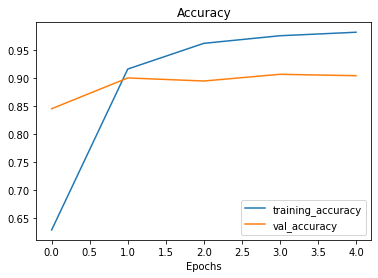

In [ ]:
plot_loss_curves(history_model_2)

In [ ]:
# Create a helper function to compare our results
def compare_results(old_model_results, new_model_results):
  for key, value in old_model_results.items():
    print(f"Old {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

In [ ]:
# Compare model_1's results with model_2's results
compare_results(old_model_results=model_1_results, 
                new_model_results=model_2_results)

Old accuracy: 88.15, New accuracy: 90.15, Difference: 2.00
Old precision: 0.88, New precision: 0.90, Difference: 0.02
Old recall: 0.88, New recall: 0.90, Difference: 0.02
Old f1: 0.88, New f1: 0.90, Difference: 0.02


## Model 3: GRU

In [ ]:
# Create embedding layer
model_3_embedding = layers.Embedding(input_dim=len(text_vocab),
                                     output_dim=128,
                                     mask_zero=True,
                                     name="embedding_3")
# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = model_3_embedding(x)
#x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, you need to set return_sequences=True
#x = layers.GlobalAveragePooling1D()(x)
x = layers.GRU(48)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
# Get a summary of the model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 41)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 41, 128)           1945600   
_________________________________________________________________
gru (GRU)                    (None, 48)                25632     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 294       
Total params: 1,971,526
Trainable params: 1,971,526
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_model_3 = model_3.fit(train_dataset,
                              epochs=5,
                              validation_data=val_dataset)

Epoch 1/5
500/500 [==============================] - 16s 22ms/step - loss: 1.0436 - accuracy: 0.6154 - val_loss: 0.3811 - val_accuracy: 0.8890
Epoch 2/5
500/500 [==============================] - 10s 20ms/step - loss: 0.2055 - accuracy: 0.9280 - val_loss: 0.2172 - val_accuracy: 0.9245
Epoch 3/5
500/500 [==============================] - 10s 20ms/step - loss: 0.0997 - accuracy: 0.9588 - val_loss: 0.2212 - val_accuracy: 0.9250
Epoch 4/5
500/500 [==============================] - 10s 20ms/step - loss: 0.0713 - accuracy: 0.9741 - val_loss: 0.2230 - val_accuracy: 0.9270
Epoch 5/5
500/500 [==============================] - 10s 20ms/step - loss: 0.0529 - accuracy: 0.9806 - val_loss: 0.2503 - val_accuracy: 0.9250


In [ ]:
# Evaluate the model on the test_dataset
model_3.evaluate(test_dataset)

63/63 [==============================] - 0s 8ms/step - loss: 0.2213 - accuracy: 0.9215


[0.221339613199234, 0.921500027179718]

In [ ]:
class_names

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [ ]:
# Make predictions with GRU model
model_3_pred_probs = model_3.predict(test_sentences)
model_3_pred_probs

array([[3.2212868e-04, 3.1460881e-05, 6.7894312e-06, 2.8715021e-06,
        9.9962163e-01, 1.5084717e-05],
       [2.3963365e-04, 1.0119731e-05, 1.2049698e-04, 1.0582206e-06,
        9.9962699e-01, 1.6753968e-06],
       [3.4833440e-04, 2.6139160e-05, 4.2420965e-05, 6.4439257e-05,
        9.9950361e-01, 1.5053162e-05],
       ...,
       [1.0278473e-02, 7.3639158e-04, 8.6141402e-01, 1.2544776e-01,
        1.7619014e-03, 3.6145994e-04],
       [1.9909018e-04, 6.9529201e-06, 9.9804938e-01, 3.6289584e-04,
        1.3776639e-03, 4.0141490e-06],
       [1.7923319e-04, 6.6323441e-01, 1.3377389e-04, 2.2318847e-03,
        5.5605854e-04, 3.3366463e-01]], dtype=float32)

In [ ]:
# Convert model_3_pred_probs to labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 4, ..., 2, 2, 1])>

In [ ]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 92.15,
 'f1': 0.9212009256335677,
 'precision': 0.9210841060054398,
 'recall': 0.9215}

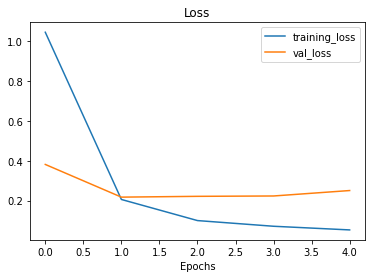

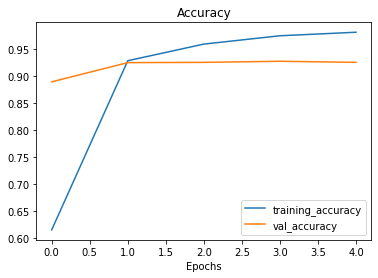

In [ ]:
plot_loss_curves(history_model_3)

In [ ]:
# Compare model_2's results with model_3's results
compare_results(old_model_results=model_2_results, 
                new_model_results=model_3_results)

Old accuracy: 90.15, New accuracy: 92.15, Difference: 2.00
Old precision: 0.90, New precision: 0.92, Difference: 0.02
Old recall: 0.90, New recall: 0.92, Difference: 0.02
Old f1: 0.90, New f1: 0.92, Difference: 0.02


## Model 4: Bidirectional LSTM

In [ ]:
# Create embedding layer
model_4_embedding = layers.Embedding(input_dim=len(text_vocab),
                                     output_dim=128,
                                     mask_zero=True,
                                     name="embedding_4")

# Build a bidirectional RNN
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(24))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [ ]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 41)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 41, 128)           1945600   
_________________________________________________________________
bidirectional (Bidirectional (None, 48)                29376     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 294       
Total params: 1,975,270
Trainable params: 1,975,270
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_model_4 = model_4.fit(train_dataset,
                              epochs=5,
                              validation_data=val_dataset)

Epoch 1/5
500/500 [==============================] - 28s 39ms/step - loss: 1.0004 - accuracy: 0.6421 - val_loss: 0.5119 - val_accuracy: 0.8275
Epoch 2/5
500/500 [==============================] - 17s 33ms/step - loss: 0.2301 - accuracy: 0.9212 - val_loss: 0.3026 - val_accuracy: 0.9005
Epoch 3/5
500/500 [==============================] - 17s 33ms/step - loss: 0.1004 - accuracy: 0.9659 - val_loss: 0.3351 - val_accuracy: 0.9035
Epoch 4/5
500/500 [==============================] - 17s 33ms/step - loss: 0.0611 - accuracy: 0.9806 - val_loss: 0.3365 - val_accuracy: 0.8965
Epoch 5/5
500/500 [==============================] - 17s 33ms/step - loss: 0.0377 - accuracy: 0.9874 - val_loss: 0.4769 - val_accuracy: 0.8845


In [ ]:
# Evaluate the model on the test_dataset
model_4.evaluate(test_dataset)

63/63 [==============================] - 1s 13ms/step - loss: 0.4678 - accuracy: 0.8900


[0.46777352690696716, 0.8899999856948853]

In [ ]:
# Make predictions with the bidirectional model
model_4_pred_probs = model_4.predict(test_sentences)
model_4_pred_probs

array([[4.98996233e-04, 1.52335910e-04, 1.11292225e-04, 4.32591514e-06,
        9.99232054e-01, 9.71182999e-07],
       [1.06231731e-04, 2.56845778e-05, 1.56050781e-04, 1.54803674e-05,
        9.99695182e-01, 1.41679106e-06],
       [3.36384110e-04, 4.10819659e-04, 4.52013279e-04, 5.16367181e-05,
        9.98744130e-01, 4.97700830e-06],
       ...,
       [2.42474812e-06, 2.14006968e-06, 9.99973297e-01, 1.22629326e-05,
        9.87587737e-06, 6.03325461e-08],
       [2.11714996e-06, 4.24607570e-05, 9.96116161e-01, 2.36462747e-05,
        3.81476316e-03, 8.77890443e-07],
       [1.67301428e-02, 5.14044762e-01, 6.46572141e-03, 3.62161454e-03,
        5.68769639e-04, 4.58568990e-01]], dtype=float32)

In [ ]:
# Convert model_4_pred_probs to labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 4, ..., 2, 2, 1])>

In [ ]:
# Calculate model 4 results
model_4_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 89.0,
 'f1': 0.8878980351059642,
 'precision': 0.8901224247422618,
 'recall': 0.89}

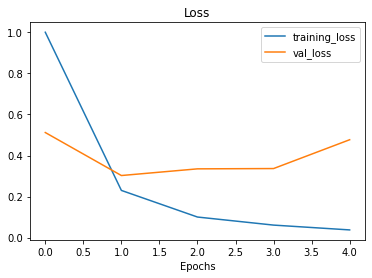

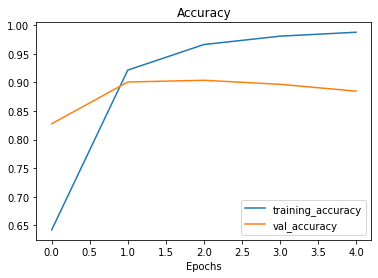

In [ ]:
plot_loss_curves(history_model_4)

In [ ]:
# Compare model_3's results with model_4's results
compare_results(old_model_results=model_3_results, 
                new_model_results=model_4_results)

Old accuracy: 92.15, New accuracy: 89.00, Difference: -3.15
Old precision: 0.92, New precision: 0.89, Difference: -0.03
Old recall: 0.92, New recall: 0.89, Difference: -0.03
Old f1: 0.92, New f1: 0.89, Difference: -0.03


## Model 5: TensorFlow Hub Pretrained (USE)

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_sample = embed(["It is a sunny day but it might rain because we're living in England."])
print(embed_sample[0][:50])

tf.Tensor(
[ 0.01969089 -0.01172203  0.01516425  0.0460484  -0.01095777  0.0595981
 -0.05272774 -0.05420118  0.07581246  0.01609087 -0.04979602 -0.06429223
 -0.03987593  0.08609369  0.01339707 -0.08656326 -0.00131273  0.05613713
  0.05545615 -0.04708892  0.04151725 -0.01545368  0.09623946  0.02641501
  0.01033185 -0.01502114 -0.00611564 -0.01057372  0.00980237  0.05312831
  0.06635482  0.02078066 -0.02402302  0.03102121  0.01798203 -0.05440179
  0.05768922 -0.09093191 -0.00769321 -0.00387448  0.04412679 -0.01284573
  0.00250211  0.09464798 -0.10412336 -0.02218963 -0.02710059  0.03872306
 -0.05890216  0.01801249], shape=(50,), dtype=float32)


In [ ]:
embed_sample

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 0.01969089, -0.01172203,  0.01516425,  0.0460484 , -0.01095777,
         0.0595981 , -0.05272774, -0.05420118,  0.07581246,  0.01609087,
        -0.04979602, -0.06429223, -0.03987593,  0.08609369,  0.01339707,
        -0.08656326, -0.00131273,  0.05613713,  0.05545615, -0.04708892,
         0.04151725, -0.01545368,  0.09623946,  0.02641501,  0.01033185,
        -0.01502114, -0.00611564, -0.01057372,  0.00980237,  0.05312831,
         0.06635482,  0.02078066, -0.02402302,  0.03102121,  0.01798203,
        -0.05440179,  0.05768922, -0.09093191, -0.00769321, -0.00387448,
         0.04412679, -0.01284573,  0.00250211,  0.09464798, -0.10412336,
        -0.02218963, -0.02710059,  0.03872306, -0.05890216,  0.01801249,
         0.02907106, -0.09269992,  0.04387783,  0.01240255,  0.00549322,
        -0.00131069, -0.01430398, -0.10571989, -0.05474945,  0.06855348,
        -0.0042415 , -0.04233855,  0.04647706, -0.0368484 , -0.02025764,
 

Create a Keras Layer using the USE pretrained layer from tensorflow hub 

**`We can use this encoding layer in place of our text_vectorizer and embedding layer`**

In [ ]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [ ]:
from tensorflow.keras import layers
# Create model using Sequential API
model_5 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(128, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(num_classes, activation="softmax")
], name="model_5_USE")

In [ ]:
# Get a summary of the model
model_5.summary()

Model: "model_5_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
Total params: 256,872,134
Trainable params: 74,310
Non-trainable params: 256,797,824
_________________________________________________________________


The trainable parameters are only in our output layers, in other words, we're keeping the USE weights frozen and using it as a feature-extractor. We could fine-tune these weights by setting `trainable=True` when creating the `hub.KerasLayer` instance.

In [ ]:
# Compile the model
model_5.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_model_5 = model_5.fit(train_dataset,
                              epochs=5,
                              validation_data=val_dataset)

Epoch 1/5
500/500 [==============================] - 12s 18ms/step - loss: 1.1134 - accuracy: 0.5880 - val_loss: 0.9573 - val_accuracy: 0.6440
Epoch 2/5
500/500 [==============================] - 9s 17ms/step - loss: 0.9188 - accuracy: 0.6567 - val_loss: 0.9213 - val_accuracy: 0.6530
Epoch 3/5
500/500 [==============================] - 9s 17ms/step - loss: 0.8579 - accuracy: 0.6796 - val_loss: 0.8974 - val_accuracy: 0.6625
Epoch 4/5
500/500 [==============================] - 9s 17ms/step - loss: 0.7958 - accuracy: 0.7026 - val_loss: 0.8787 - val_accuracy: 0.6710
Epoch 5/5
500/500 [==============================] - 9s 17ms/step - loss: 0.7298 - accuracy: 0.7283 - val_loss: 0.8680 - val_accuracy: 0.6770


In [ ]:
# Evaluate on test_dataset
model_5.evaluate(test_dataset)

63/63 [==============================] - 1s 15ms/step - loss: 0.8786 - accuracy: 0.6780


[0.8785730004310608, 0.6779999732971191]

In [ ]:
# Make predictions with USE TF Hub Model
model_5_pred_probs = model_5.predict(test_sentences)
model_5_pred_probs[:10]

array([[2.2164083e-01, 1.0976720e-02, 9.9761829e-02, 1.4175279e-02,
        6.5276468e-01, 6.8064209e-04],
       [1.3885952e-02, 5.0165434e-03, 2.5319409e-01, 1.4587131e-03,
        7.2500700e-01, 1.4376873e-03],
       [1.3070997e-02, 7.8759920e-03, 1.5286724e-02, 1.9796306e-02,
        9.4345498e-01, 5.1499513e-04],
       [5.9967386e-03, 1.4834011e-02, 6.2190759e-01, 2.9811805e-01,
        5.8469728e-02, 6.7383319e-04],
       [1.6397055e-02, 2.2518220e-03, 2.9157970e-02, 3.0728884e-04,
        9.5051408e-01, 1.3717607e-03],
       [7.5605258e-02, 6.1086434e-01, 9.6651353e-03, 2.6851655e-03,
        2.9559872e-01, 5.5813929e-03],
       [9.3556523e-01, 4.3536369e-02, 2.1466552e-03, 7.1282045e-04,
        1.7719911e-02, 3.1905019e-04],
       [5.2174147e-02, 1.1792736e-01, 4.6829423e-01, 2.8252253e-01,
        6.4794436e-02, 1.4287255e-02],
       [2.8458631e-02, 3.1073925e-01, 5.3779441e-01, 6.0781885e-02,
        4.7406156e-02, 1.4819596e-02],
       [5.0077003e-01, 7.7217683e-02,

In [ ]:
# Convert model_5_pred_probs to labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 4, ..., 2, 1, 4])>

In [ ]:
# Calculate model 5 results
model_5_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 67.80000000000001,
 'f1': 0.6712691216450727,
 'precision': 0.6738824147189975,
 'recall': 0.678}

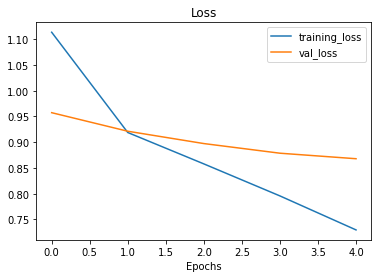

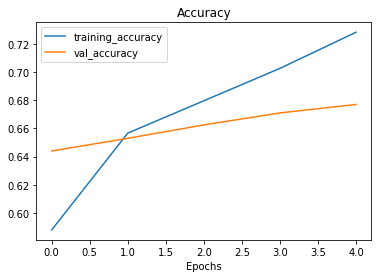

In [ ]:
plot_loss_curves(history_model_5)

In [ ]:
# Compare model_4's results with model_5's results
compare_results(old_model_results=model_4_results, 
                new_model_results=model_5_results)

Old accuracy: 89.00, New accuracy: 67.80, Difference: -21.20
Old precision: 0.89, New precision: 0.67, Difference: -0.22
Old recall: 0.89, New recall: 0.68, Difference: -0.21
Old f1: 0.89, New f1: 0.67, Difference: -0.22


Comparing the performance of each of our models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_conv1d": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional_lstm": model_4_results,
                                  "5_tf_hub_use_encoder": model_5_results})
all_model_results = all_model_results.transpose()

In [ ]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.3315,0.243748,0.3315,0.266659
1_conv1d,0.8815,0.881264,0.8815,0.879967
2_lstm,0.9015,0.903141,0.9015,0.901656
3_gru,0.9215,0.921084,0.9215,0.921201
4_bidirectional_lstm,0.8900,0.890122,0.8900,0.887898
5_tf_hub_use_encoder,0.6780,0.673882,0.6780,0.671269


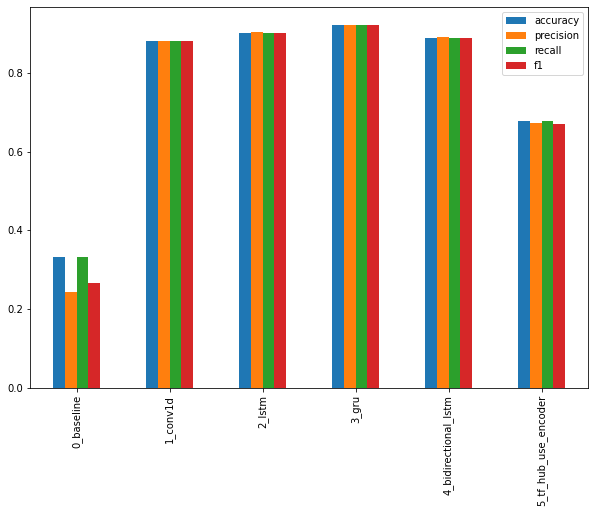

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

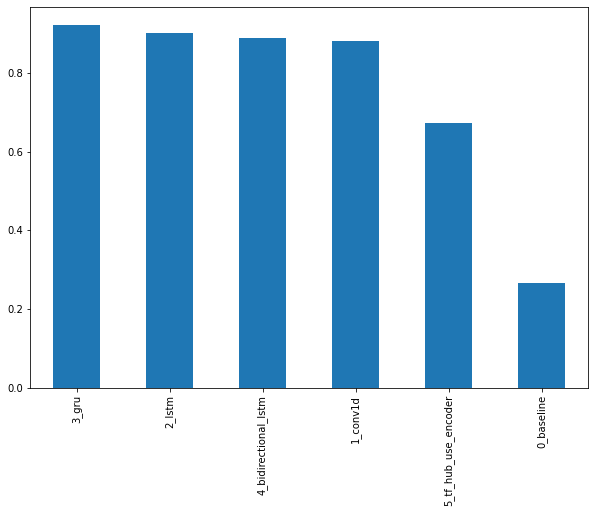

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));

## Model 6: Conv1D with character embeddings

### Creating a character-level tokenizer

Before we can vectorize our sequences on a character-level we'll need to split them into characters.

In [ ]:
# Make a function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level-sequence into characters
split_chars(train_sentences[0])

'i   d i d n t   f e e l   h u m i l i a t e d'

Now, create character-level datasets by splitting our sequence datasets into characters.

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[1]

'i   c a n   g o   f r o m   f e e l i n g   s o   h o p e l e s s   t o   s o   d a m n e d   h o p e f u l   j u s t   f r o m   b e i n g   a r o u n d   s o m e o n e   w h o   c a r e s   a n d   i s   a w a k e'

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

96.8458125

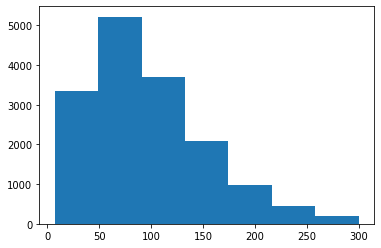

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

Looks like most of our sequences are between 0 and 210 characters long. Let's use NumPy's percentile to figure out what length covers 95% of our sequences

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

207

Now we know the sequence length which covers 95% of sequences, we'll use that in our `TextVectorization` layer as the `output_sequence_length` parameter.

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

Check some characteristics about it using the [`get_vocabulary()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization#get_vocabulary) method.

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'j', 'x', 'z', 'q']


We can also test it on random sequences of characters to make sure it's working.

In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
i   d o   f e e l   a m u s e d   b y   a l l   t h e   d i f f e r e n t   d e b a t e s   g o i n g   o n   b u t   o n   t h e   o t h e r   h a n d   i   f e l t   t h a t   t h e r e s   s o m e t h i n g   m i s s i n g

Length of chars: 92

Vectorized chars:
[[ 4 12  6 13  2  2  9  5 14 15  8  2 12 21 17  5  9  9  3 11  2 12  4 13
  13  2 10  2  7  3 12  2 21  5  3  2  8 16  6  4  7 16  6  7 21 15  3  6
   7  3 11  2  6  3 11  2 10 11  5  7 12  4 13  2  9  3  3 11  5  3  3 11
   2 10  2  8  8  6 14  2  3 11  4  7 16 14  4  8  8  4  7 16  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]

Length of vectorized chars: 207


Due to the `standardize` parameter of `TextVectorization` being `"lower_and_strip_punctuation"` and the `split` parameter being `"whitespace"` by default, symbols (such as `@`) and spaces are removed.

> 🔑 **Note:** If you didn't want punctuation to be removed (keep the `@`, `%` etc), you can create a custom standardization callable and pass it as the `standardize` parameter. See the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) class documentation for more.

### Creating a character-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character
                              mask_zero=False,
                              name="char_embed")

In [ ]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
i   d o   f e e l   a m u s e d   b y   a l l   t h e   d i f f e r e n t   d e b a t e s   g o i n g   o n   b u t   o n   t h e   o t h e r   h a n d   i   f e l t   t h a t   t h e r e s   s o m e t h i n g   m i s s i n g

Embedded chars (after vectorization and embedding):
[[[-0.03156579  0.03055898 -0.01202937 ...  0.01212375  0.01337251
   -0.02300602]
  [ 0.00996823  0.02686616  0.02111086 ... -0.02235138 -0.04143375
   -0.0391358 ]
  [-0.01758847 -0.00164231  0.00163567 ... -0.04937947 -0.03575096
   -0.00676493]
  ...
  [-0.04650636 -0.04777044  0.03623749 ...  0.00427871 -0.03716878
   -0.011065  ]
  [-0.04650636 -0.04777044  0.03623749 ...  0.00427871 -0.03716878
   -0.011065  ]
  [-0.04650636 -0.04777044  0.03623749 ...  0.00427871 -0.03716878
   -0.011065  ]]]

Character embedding shape: (1, 207, 25)


Each of the characters in our sequences gets turned into a 25 dimension embedding.

### Building a Conv1D model to fit on character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=3, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_6 = tf.keras.Model(inputs, outputs, name="model_6_conv1D_char_embedding")

In [ ]:
# Compile model
model_6.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get the summary of the model
model_6.summary()

Model: "model_6_conv1D_char_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 207)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 207, 25)           1750      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 207, 64)           4864      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 7,004
Trainable params: 7,004
Non-trainable params: 0
___________________________________

Before fitting our model on the data, we'll create char-level batched `PrefetchedDataset`'s.

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 6)), types: (tf.string, tf.float64)>

In [ ]:
# Fit the model
history_model_6 = model_6.fit(train_char_dataset,
                              epochs=5,
                              validation_data=val_char_dataset)

Epoch 1/5
500/500 [==============================] - 5s 8ms/step - loss: 1.5706 - accuracy: 0.3593 - val_loss: 1.5475 - val_accuracy: 0.3895
Epoch 2/5
500/500 [==============================] - 4s 8ms/step - loss: 1.5042 - accuracy: 0.4006 - val_loss: 1.4695 - val_accuracy: 0.4135
Epoch 3/5
500/500 [==============================] - 4s 8ms/step - loss: 1.4183 - accuracy: 0.4440 - val_loss: 1.3920 - val_accuracy: 0.4610
Epoch 4/5
500/500 [==============================] - 4s 8ms/step - loss: 1.3427 - accuracy: 0.4814 - val_loss: 1.3264 - val_accuracy: 0.4900
Epoch 5/5
500/500 [==============================] - 4s 8ms/step - loss: 1.2804 - accuracy: 0.5109 - val_loss: 1.2747 - val_accuracy: 0.5120


In [ ]:
# Evaluate model on test dataset
model_6.evaluate(test_char_dataset)

63/63 [==============================] - 0s 5ms/step - loss: 1.2743 - accuracy: 0.5350


[1.2742613554000854, 0.5350000262260437]

In [ ]:
# Make predictions 
model_6_pred_probs = model_6.predict(test_chars)
model_6_pred_probs[:10]

array([[0.50350064, 0.12949003, 0.13095126, 0.0387883 , 0.17315379,
        0.02411599],
       [0.1216985 , 0.08344898, 0.22026499, 0.04302584, 0.51760405,
        0.01395763],
       [0.09603541, 0.08695109, 0.18468912, 0.05225391, 0.55517524,
        0.02489522],
       [0.06978887, 0.1932539 , 0.3367017 , 0.07826418, 0.3129402 ,
        0.00905113],
       [0.05628619, 0.22921431, 0.07247787, 0.04205844, 0.5900106 ,
        0.0099526 ],
       [0.02107694, 0.55458045, 0.14975706, 0.04385234, 0.22466825,
        0.00606496],
       [0.11369155, 0.17542352, 0.3532835 , 0.11052483, 0.22486703,
        0.02220957],
       [0.09515888, 0.1563081 , 0.4810178 , 0.0905764 , 0.15349591,
        0.0234429 ],
       [0.04902472, 0.08503257, 0.50548303, 0.14498402, 0.19157219,
        0.02390344],
       [0.2974246 , 0.14177537, 0.35350615, 0.0496997 , 0.1342772 ,
        0.02331706]], dtype=float32)

In [ ]:
# Convert model_6_pred_probs to labels
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
model_6_preds

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([0, 4, 4, ..., 2, 2, 2])>

In [ ]:
# Calculate model 6 results
model_6_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 53.5,
 'f1': 0.5019451311050954,
 'precision': 0.5162269627174856,
 'recall': 0.535}

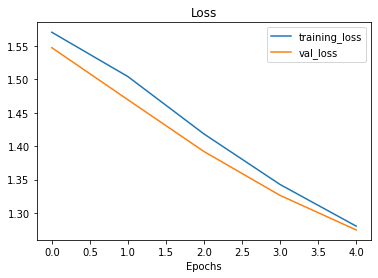

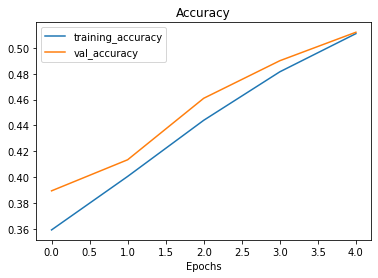

In [ ]:
plot_loss_curves(history_model_6)

In [ ]:
# Compare model_5's results with model_6's results
compare_results(old_model_results=model_5_results, 
                new_model_results=model_6_results)

Old accuracy: 67.80, New accuracy: 53.50, Difference: -14.30
Old precision: 0.67, New precision: 0.52, Difference: -0.16
Old recall: 0.68, New recall: 0.54, Difference: -0.14
Old f1: 0.67, New f1: 0.50, Difference: -0.17


## Model 7: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inptus/model
## Create a new char embedding layer
char_embed_2 = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character
                              mask_zero=False,
                              name="char_embed_2")

char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed_2(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with chat and token inputs
model_7 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_7_token_char_embedding")

In [ ]:
# Get summary of the model
model_7.summary()

Model: "model_7_token_char_embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 207)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
USE (KerasLayer)                (None, 512)          256797824   token_inputs[0][0]               
_______________________________________________________________________

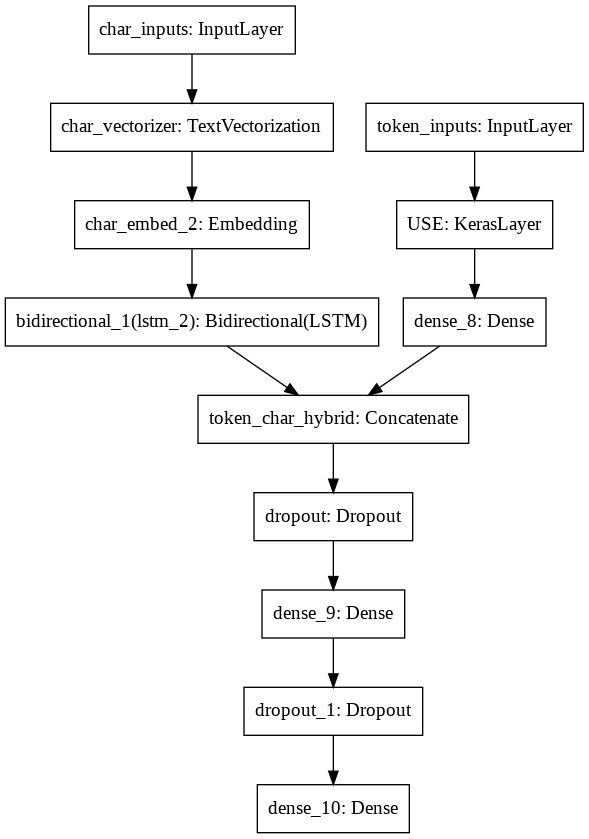

In [ ]:
# Plot hybrid (token and character) model
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [ ]:
# Compile token char model
model_7.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

### Combining token and character data into a `tf.data` dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps for test data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset, test_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 6)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 6)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 6)), types: ((tf.string, tf.string), tf.float64)>)

### Fitting the model

In [ ]:
# Fit the model
history_model_7 = model_7.fit(train_char_token_dataset,
                              epochs=5,
                              validation_data=val_char_token_dataset)

Epoch 1/5
500/500 [==============================] - 51s 93ms/step - loss: 1.2253 - accuracy: 0.5479 - val_loss: 1.0021 - val_accuracy: 0.6325
Epoch 2/5
500/500 [==============================] - 45s 90ms/step - loss: 1.0150 - accuracy: 0.6315 - val_loss: 0.9454 - val_accuracy: 0.6470
Epoch 3/5
500/500 [==============================] - 45s 89ms/step - loss: 0.9568 - accuracy: 0.6450 - val_loss: 0.9137 - val_accuracy: 0.6540
Epoch 4/5
500/500 [==============================] - 45s 89ms/step - loss: 0.9114 - accuracy: 0.6657 - val_loss: 0.8954 - val_accuracy: 0.6615
Epoch 5/5
500/500 [==============================] - 45s 89ms/step - loss: 0.8756 - accuracy: 0.6787 - val_loss: 0.8746 - val_accuracy: 0.6695


In [ ]:
# Evaluate the model on test_char_token_dataset
model_7.evaluate(test_char_token_dataset)

63/63 [==============================] - 3s 41ms/step - loss: 0.8888 - accuracy: 0.6625


[0.8887595534324646, 0.6625000238418579]

In [ ]:
# Make predictions 
model_7_pred_probs = model_7.predict(test_char_token_dataset)
model_7_pred_probs[:10]

array([[1.3544181e-01, 1.2857021e-02, 9.8954484e-02, 8.1375279e-03,
        7.4026215e-01, 4.3470250e-03],
       [8.3897710e-03, 1.5359706e-03, 3.6551807e-02, 3.4972883e-04,
        9.5278418e-01, 3.8854405e-04],
       [9.8980516e-03, 6.0432251e-03, 1.1738925e-02, 4.3844222e-03,
        9.6759361e-01, 3.4173980e-04],
       [1.9873880e-02, 1.4686686e-02, 5.4542685e-01, 3.5626566e-01,
        6.0671125e-02, 3.0757925e-03],
       [5.7521742e-02, 7.6097837e-03, 8.6056106e-02, 1.2129718e-03,
        8.4289521e-01, 4.7040679e-03],
       [3.3571873e-02, 7.1813822e-01, 1.3631918e-02, 2.0210154e-03,
        2.2213140e-01, 1.0505528e-02],
       [8.8920283e-01, 7.0353881e-02, 2.2888226e-03, 5.2877003e-04,
        3.7403699e-02, 2.2202387e-04],
       [9.2009999e-02, 1.9620886e-01, 3.7498516e-01, 2.0831455e-01,
        9.0704858e-02, 3.7776530e-02],
       [3.2901548e-02, 3.7791017e-01, 4.3026140e-01, 5.6001469e-02,
        4.1958384e-02, 6.0967114e-02],
       [2.6721159e-01, 7.8542031e-02,

In [ ]:
# Convert model_7_pred_probs to labels
model_7_preds = tf.argmax(model_7_pred_probs, axis=1)
model_7_preds

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 4, ..., 2, 1, 4])>

In [ ]:
# Turn prediction probabilities into prediction classes
model_7_preds = tf.argmax(model_7_pred_probs, axis=1)
model_7_preds

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 4, ..., 2, 1, 4])>

In [ ]:
# Get results of token-char-hybrid model
model_7_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 66.25,
 'f1': 0.6513969473623079,
 'precision': 0.6554372159703059,
 'recall': 0.6625}

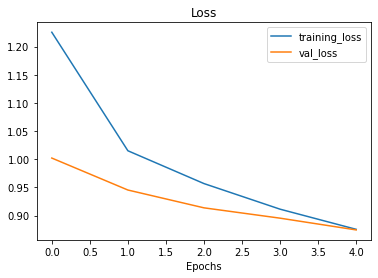

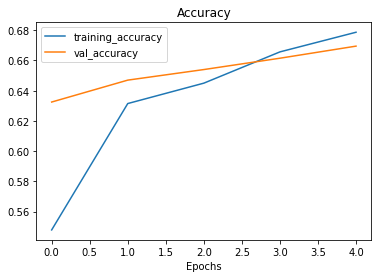

In [ ]:
plot_loss_curves(history_model_7)

In [ ]:
# Compare model_6's results with model_7's results
compare_results(old_model_results=model_6_results, 
                new_model_results=model_7_results)

Old accuracy: 53.50, New accuracy: 66.25, Difference: 12.75
Old precision: 0.52, New precision: 0.66, Difference: 0.14
Old recall: 0.54, New recall: 0.66, Difference: 0.13
Old f1: 0.50, New f1: 0.65, Difference: 0.15


## Model 8: Transfer Learning with Fine-tuned token embeddings + character embeddings

In [ ]:
# 1. Token inputs/model
## Create a new embedding layer
sentence_encoder_layer_trainable = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                  input_shape=[], # shape of inputs coming to our model 
                                                  dtype=tf.string, # data type of inputs coming to the USE layer
                                                  trainable=True, # Fine-tuning
                                                  name="USE_Trainable")

token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = sentence_encoder_layer_trainable(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs/model
## Create a new char embedding layer
char_embed_3 = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character
                              mask_zero=False,
                              name="char_embed_3")

char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed_3(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (chreate hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(152, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Construct model with char and token inputs
model_8 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_8_trained_token_and_char_embeddings")

In [ ]:
# Get a summary of the model
model_8.summary()

Model: "model_8_trained_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 207)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
USE_Trainable (KerasLayer)      (None, 512)          256797824   token_inputs[0][0]               
__________________________________________________________

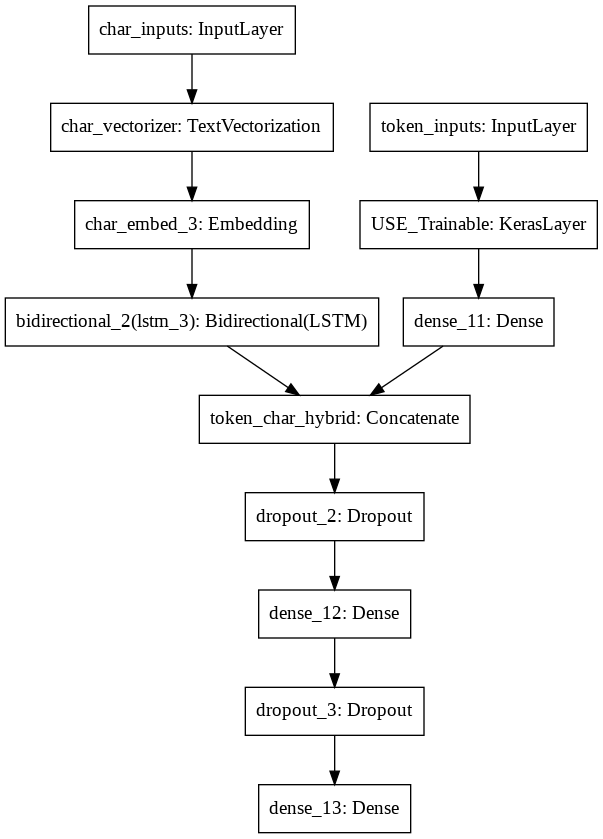

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_8)

In [ ]:
# Compile token char model
model_8.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_model_8 = model_8.fit(train_char_token_dataset,
                              epochs=5,
                              validation_data=val_char_token_dataset)

Epoch 1/5
500/500 [==============================] - 150s 279ms/step - loss: 1.1089 - accuracy: 0.5970 - val_loss: 0.7092 - val_accuracy: 0.7455
Epoch 2/5
500/500 [==============================] - 138s 275ms/step - loss: 0.3341 - accuracy: 0.8917 - val_loss: 0.6475 - val_accuracy: 0.8115
Epoch 3/5
500/500 [==============================] - 137s 274ms/step - loss: 0.0857 - accuracy: 0.9759 - val_loss: 0.8264 - val_accuracy: 0.8035
Epoch 4/5
500/500 [==============================] - 137s 274ms/step - loss: 0.0354 - accuracy: 0.9910 - val_loss: 0.9621 - val_accuracy: 0.7995
Epoch 5/5
500/500 [==============================] - 138s 276ms/step - loss: 0.0271 - accuracy: 0.9937 - val_loss: 1.0391 - val_accuracy: 0.8025


In [ ]:
# Evaluate model on test_char_token_dataset
model_8.evaluate(test_char_token_dataset)

63/63 [==============================] - 3s 41ms/step - loss: 1.0965 - accuracy: 0.7830


[1.0965262651443481, 0.7829999923706055]

In [ ]:
# Make predictions 
model_8_pred_probs = model_8.predict(test_char_token_dataset)
model_8_pred_probs[:10]

array([[7.10141539e-05, 1.58906445e-07, 2.97734886e-07, 1.11187033e-08,
        9.99928474e-01, 8.14482440e-11],
       [2.50610185e-07, 2.80501649e-08, 2.89611023e-07, 3.73588827e-10,
        9.99999404e-01, 6.67145245e-12],
       [1.20188331e-03, 8.68747011e-05, 9.21109950e-06, 8.61585193e-07,
        9.98700976e-01, 1.51816266e-07],
       [2.99249892e-04, 3.57358367e-05, 9.90231335e-01, 7.90893473e-03,
        1.49897381e-03, 2.57734537e-05],
       [1.87527519e-04, 6.82468169e-07, 5.77565004e-07, 1.18633309e-07,
        9.99811113e-01, 1.35973810e-09],
       [1.46128485e-04, 9.99622345e-01, 1.48461031e-05, 9.47032248e-08,
        7.99968475e-05, 1.36612347e-04],
       [9.99982715e-01, 8.60018463e-06, 1.21061419e-07, 6.86102396e-07,
        7.75988883e-06, 1.01363057e-07],
       [2.86877155e-03, 2.32517457e-04, 1.11767597e-01, 8.82620215e-01,
        1.49584934e-03, 1.01500982e-03],
       [3.27309522e-07, 2.88530027e-05, 9.99783695e-01, 1.18731536e-04,
        2.79038682e-06, 

In [ ]:
# Convert model_7_pred_probs to labels
model_8_preds = tf.argmax(model_8_pred_probs, axis=1)
model_8_preds

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 4, ..., 2, 2, 1])>

In [ ]:
# Turn prediction probabilities into prediction classes
model_8_preds = tf.argmax(model_8_pred_probs, axis=1)
model_8_preds

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 4, ..., 2, 2, 1])>

In [ ]:
# Get results of token-char-hybrid model
model_8_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_8_preds)
model_8_results

{'accuracy': 78.3,
 'f1': 0.7849368804849955,
 'precision': 0.8006802836218437,
 'recall': 0.783}

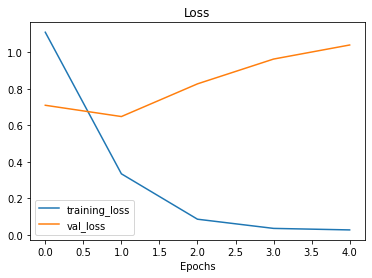

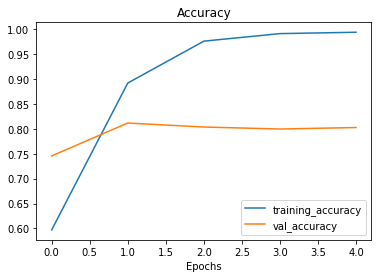

In [ ]:
plot_loss_curves(history_model_8)

In [ ]:
# Compare model_7's results with model_8's results
compare_results(old_model_results=model_7_results, 
                new_model_results=model_8_results)

Old accuracy: 66.25, New accuracy: 78.30, Difference: 12.05
Old precision: 0.66, New precision: 0.80, Difference: 0.15
Old recall: 0.66, New recall: 0.78, Difference: 0.12
Old f1: 0.65, New f1: 0.78, Difference: 0.13


Comparing the performance of each of our models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_conv1d": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional_lstm": model_4_results,
                                  "5_tf_hub_use_encoder": model_5_results,
                                  "6_conv1D_char_embedding": model_6_results,
                                  "7_token_char_embedding": model_7_results,
                                  "8_trained_token_and_char_embeddings": model_8_results})
all_model_results = all_model_results.transpose()

In [ ]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.3315,0.243748,0.3315,0.266659
1_conv1d,0.8815,0.881264,0.8815,0.879967
2_lstm,0.9015,0.903141,0.9015,0.901656
3_gru,0.9215,0.921084,0.9215,0.921201
4_bidirectional_lstm,0.8900,0.890122,0.8900,0.887898
5_tf_hub_use_encoder,0.6780,0.673882,0.6780,0.671269
6_conv1D_char_embedding,0.5350,0.516227,0.5350,0.501945
7_token_char_embedding,0.6625,0.655437,0.6625,0.651397
8_trained_token_and_char_embeddings,0.7830,0.800680,0.7830,0.784937


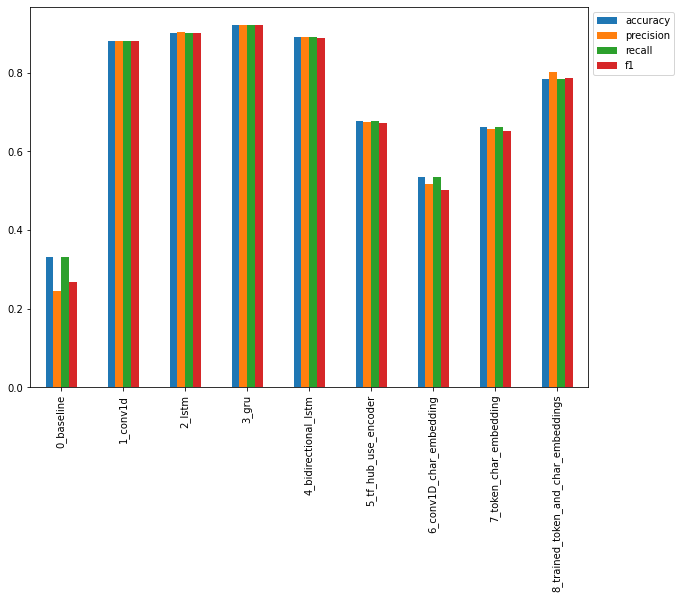

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

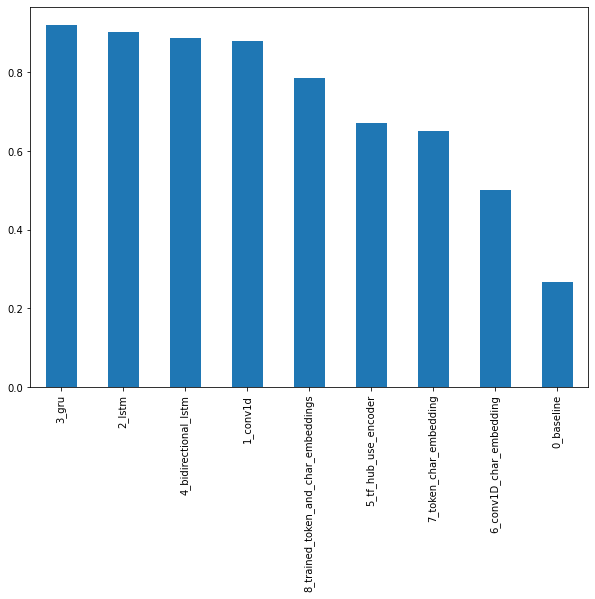

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));

# BERT

## Model 9: Using Bert as a Tokenizer

In [ ]:
# Import dependencies
!pip install bert-for-tf2
import tensorflow_hub as hub

     |████████████████████████████████| 41 kB 131 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=33ad10d4748bf1127e7b4c95782420c68fe603500ca3b59bdcd1a34f0d0fe08a
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19473 sha256=f9648d8ee4c59205921c2511b58f84a5afe6f7991f4e7d038757d00804bda6a6
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7912 sha256=599d44a8b3391716a21cdc89528615791ac068daa8cedf0a32b6f72d78d4c44b
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow py-params


In [ ]:
import bert

In [ ]:
full_tokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = full_tokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.tokenize("my dog loves strawberries.")

['my', 'dog', 'loves', 'straw', '##berries', '.']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("my dog loves strawberries."))

[2026, 3899, 7459, 13137, 20968, 1012]

In [ ]:
def encode_sentence(sentence):
  return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence))

In [ ]:
bert_train_sentences = [encode_sentence(sentence) for sentence in train_sentences]
bert_val_sentences = [encode_sentence(sentence) for sentence in val_sentences]
bert_test_sentences = [encode_sentence(sentence) for sentence in test_sentences]

In [ ]:
bert_train_sentences[0]

[1045, 2134, 2102, 2514, 26608]

In [ ]:
def set_sequence_length(my_list, max_seq_len):
  for i in range(len(my_list)):
    if len(my_list[i]) < max_seq_len:
      my_list[i].extend([0] * (max_seq_len - len(my_list[i])))
    elif len(my_list[i]) > max_seq_len:
      my_list[i] = my_list[i][:max_seq_len]
  return my_list

In [ ]:
a = [[1,2,3,4,5], [7,8], [9,10,11], [12,13,14]]
a = set_sequence_length(a, 3)
print(a)

[[1, 2, 3], [7, 8, 0], [9, 10, 11], [12, 13, 14]]


In [ ]:
bert_train_sentences_len_equaled = set_sequence_length(bert_train_sentences, output_seq_len)
bert_val_sentences_len_equaled = set_sequence_length(bert_val_sentences, output_seq_len)
bert_test_sentences_len_equaled = set_sequence_length(bert_test_sentences, output_seq_len)

In [ ]:
# Turn our data into TensorFlow Datasets
bert_train_dataset = tf.data.Dataset.from_tensor_slices((bert_train_sentences_len_equaled, train_labels_one_hot))
bert_val_dataset = tf.data.Dataset.from_tensor_slices((bert_val_sentences_len_equaled, val_labels_one_hot))
bert_test_dataset = tf.data.Dataset.from_tensor_slices((bert_test_sentences_len_equaled, test_labels_one_hot))

In [ ]:
bert_train_dataset

<TensorSliceDataset shapes: ((41,), (6,)), types: (tf.int32, tf.float64)>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
bert_train_dataset = bert_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
bert_val_dataset = bert_val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
bert_test_dataset = bert_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

bert_train_dataset

<PrefetchDataset shapes: ((None, 41), (None, 6)), types: (tf.int32, tf.float64)>

In [ ]:
# Create an embedding layer (new embedding layer for each model)
from tensorflow.keras import layers
model_9_embedding = layers.Embedding(input_dim=len(text_vocab),
                                     output_dim=128,
                                     mask_zero=True,
                                     name="embedding_9")
# Create the model 
inputs = layers.Input(shape=(1,), dtype=tf.int32)
x = model_9_embedding(inputs)
#x = layers.Conv1D(16, kernel_size=1, padding="valid", activation="relu")(x)
x = layers.LSTM(24)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_9 = tf.keras.Model(inputs, outputs, name="model_9_BERT_Tokenizer")

In [ ]:
model_9.summary()

In [ ]:
# Compile the model
model_9.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
# Fit the model
history_model_9 = model_9.fit(bert_train_dataset,
                              epochs=5,
                              validation_data=bert_val_dataset)

###--- Another way to use BERT (probably it is a better way)---

In [21]:
!pip install tensorflow_text
import tensorflow_text as text
import tensorflow_hub as hub

     |████████████████████████████████| 4.4 MB 5.4 MB/s 


In [22]:
bert_preprocessed = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [26]:
# Bert layers
input = tf.keras.layers.Input(shape=(), dtype="string", name="input_layer")
preprocessed_text = bert_preprocessed(input)
encoded_text = bert_encoder(preprocessed_text)

# Neural network layers
x = tf.keras.layers.Dropout(0.1, name="dropout")(encoded_text["pooled_output"])
output = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model_10 = tf.keras.Model(inputs=input, outputs=output)

In [28]:
# Compile the model
model_10.compile(loss="categorical_crossentropy",
                 optimizer="Adam",
                 metrics=["accuracy"])

In [31]:
model_10.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_word_ids': ( 0           input_layer[0][0]                
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'sequence_output':  109482241   keras_layer[3][0]                
                                                                 keras_layer[3][1]                
                                                                 keras_layer[3][2]                
______________________________________________________________________________________________

In [29]:
# Fit the model
history_model_10 = model_10.fit(train_dataset,
                                epochs=5,
                                validation_data=val_dataset)

Epoch 1/5
500/500 [==============================] - 365s 705ms/step - loss: 1.5547 - accuracy: 0.3792 - val_loss: 1.4832 - val_accuracy: 0.4640
Epoch 2/5
500/500 [==============================] - 352s 705ms/step - loss: 1.4741 - accuracy: 0.4361 - val_loss: 1.4259 - val_accuracy: 0.4875
Epoch 3/5
500/500 [==============================] - 351s 702ms/step - loss: 1.4326 - accuracy: 0.4532 - val_loss: 1.3920 - val_accuracy: 0.5005
Epoch 4/5
500/500 [==============================] - 351s 702ms/step - loss: 1.4038 - accuracy: 0.4694 - val_loss: 1.3671 - val_accuracy: 0.5115
Epoch 5/5
500/500 [==============================] - 350s 701ms/step - loss: 1.3914 - accuracy: 0.4736 - val_loss: 1.3449 - val_accuracy: 0.5130


In [30]:
# Evaluate the model on test_dataset
model_10.evaluate(test_dataset)

63/63 [==============================] - 39s 616ms/step - loss: 1.3116 - accuracy: 0.5210


[1.3116121292114258, 0.5210000276565552]